# Create a 1D signal WGAN for voice recorded signals
## Use a very basic WGAN architecture that works with a single dimension (1D array)

In [1]:
import sounddevice as sd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Audio
from scipy.io.wavfile import write
import os
import torch.nn.functional as F


# Lets setup some basic configurations

In [2]:
sample_rate = 48000
duration = 1  # 2 seconds
signal_length = sample_rate * duration

In [3]:
import random
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    
seed_everything(42)

## Define the Generator class

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim=8, out_dim=1024):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, out_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

## Define the Discriminator class

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_dim=1024):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Custom dataset class for voice signals

In [6]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=22050, duration=2):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]  # Only .npy files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        # Load numpy array
        waveform = np.load(file_path)
        # Ensure the audio is 2 seconds long
        target_length = self.sample_rate * self.duration
        if waveform.size < target_length:
            # Pad the waveform if it's shorter than 2 seconds
            waveform = np.pad(waveform, (0, target_length - waveform.size), mode='constant')
        else:
            # Trim the waveform if it's longer than duration
            waveform = waveform[:target_length]
        waveform = waveform.astype(np.float32)
        waveform = (waveform - min(waveform)) / (max(waveform) - min(waveform)) * 2 - 1 
        waveform = waveform/np.max(waveform)
        return torch.tensor(waveform,dtype=torch.float32)  # Convert to tensor


## Prepare the dataset for training the GAN

In [7]:
# Create the dataset and dataloader
batch_size = 128
dataset = AudioDataset('audioMNIST/', sample_rate, duration)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataset))

30000


tensor([-0.0995, -0.0995, -0.1014,  ..., -0.0686, -0.0686, -0.0686])


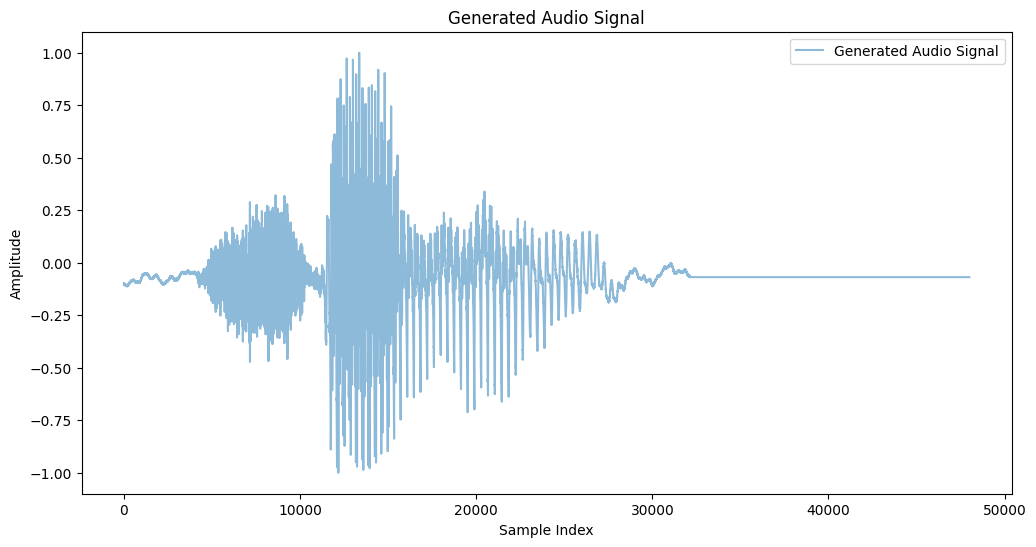

In [8]:
# plot the signal 
for batch in dataloader:
    # Plot the generated audio signal
    plt.figure(figsize=(12, 6))
    print(batch[0])
    plt.plot(batch[0], label='Generated Audio Signal', alpha=0.5)
    plt.title('Generated Audio Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    break

## Initialize the generator and discriminator

In [21]:
# Set up the GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters
latent_dim = 128
lr = 0.0005
# Initialize generator and discriminator
generator = Generator(latent_dim=latent_dim,out_dim= signal_length)
discriminator = Discriminator(in_dim=signal_length)

## Define the loss function and optimizers

In [22]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, momentum=0.9)
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.005, momentum=0.9)
num_epochs = 100

TypeError: Adam.__init__() got an unexpected keyword argument 'momentum'

In [23]:
from torch.autograd import Variable
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(1)
    # Scale to the range [-1, 1)
    alpha = alpha * 2 - 1
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Training the GAN

In [24]:
weight_clipping_limit = 0.01  # Weight clipping limit
# Lists to store losses
g_losses = []
d_losses = []
# Training loop
for epoch in range(num_epochs):
    for real_samples in dataloader: # batch is (batch_size, time_steps, features)
        # Train the discriminator
        # Generate fake signal
        z =  (-2.0)*(torch.randn(real_samples.size(0), latent_dim))-1.0
        fake_samples = generator(z).detach() # gradient wouldn't be passed down
        real_samples = real_samples
        
        real_output = discriminator(real_samples)
        # maximize predr, therefore minus sign
        lossr = -real_output.mean()
        fake_output = discriminator(fake_samples)
        lossf = fake_output.mean()

       # aggregate all - do the wassertein loss
        d_loss = lossr + lossf + 0.3*compute_gradient_penalty(discriminator,real_samples,fake_samples)
        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        # Weight clipping
        for p in discriminator.parameters():
            p.data.clamp_(-weight_clipping_limit, weight_clipping_limit)

        # Train the generator more than discriminator
        z =  (-2.0)*(torch.randn(real_samples.size(0), latent_dim))-1.0
        fake_samples = generator(z)
        fake_output = discriminator(fake_samples)
        g_loss = -fake_output.mean()
        
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Store losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
    #if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}')

Epoch: 0, Generator Loss: -0.4972628951072693, Discriminator Loss: 0.264689177274704
Epoch: 0, Generator Loss: -0.49730169773101807, Discriminator Loss: 0.29354533553123474
Epoch: 0, Generator Loss: -0.4972708821296692, Discriminator Loss: 0.2937292158603668
Epoch: 0, Generator Loss: -0.4972662031650543, Discriminator Loss: 0.29319846630096436
Epoch: 0, Generator Loss: -0.4972844421863556, Discriminator Loss: 0.2931239902973175
Epoch: 0, Generator Loss: -0.4972921907901764, Discriminator Loss: 0.29359006881713867
Epoch: 0, Generator Loss: -0.49728426337242126, Discriminator Loss: 0.29335761070251465
Epoch: 0, Generator Loss: -0.4973376393318176, Discriminator Loss: 0.29356566071510315
Epoch: 0, Generator Loss: -0.49731019139289856, Discriminator Loss: 0.2936539351940155
Epoch: 0, Generator Loss: -0.49731871485710144, Discriminator Loss: 0.29353657364845276
Epoch: 0, Generator Loss: -0.4972822368144989, Discriminator Loss: 0.29347798228263855
Epoch: 0, Generator Loss: -0.497257441282272

KeyboardInterrupt: 

## Plot the losses

In [ ]:
# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('GAN Training Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()        
        

## Generate new signals after training

In [ ]:
# Set the generator to evaluation mode
generator.eval()
# Generate and visualize a sample output
with torch.no_grad():
    z =  torch.tanh(torch.randn(1, latent_dim))
    generated_audio = generator(z).detach().numpy().flatten()
print(generated_audio.shape)
# Plot the generated audio signal
plt.figure(figsize=(12, 6))
plt.plot(generated_audio, label='Generated Audio Signal', alpha=0.5)
plt.title('Generated Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# saving the output
np.save('generated/generated.npy', generated_audio)
from scipy.io.wavfile import write

# Assuming the array values are in the range of int16 for WAV format
# Scale the array if necessary
generated_audio = np.int16(generated_audio / np.max(np.abs(generated_audio)) * 32767)

# Save the array as a WAV file
write('generated/generated.wav', sample_rate, generated_audio) 